In [78]:
# import these libraries, install if necessary.
import operator
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_classification,make_blobs,load_iris
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss, davies_bouldin_score, silhouette_score
from scipy.integrate import odeint
from collections import OrderedDict
from IPython import display
from keras.datasets import mnist
from tqdm import tqdm_notebook
# !pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')
#@title Beautifying_Plot

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

## Covid-19 Data visualisation

In [79]:
covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])

In [80]:
date = np.array(covid_data.groupby("Date", as_index=False).sum()[['Date']])

In [81]:
covid_data.head()

,Province/State,Country/Region,Lat,Long,Date,Value,ISO 3166-1 Alpha 3-Codes,Region Code,Sub-region Code,Intermediate Region Code
0,NaN,Afghanistan,33.93911,67.709953,2021-06-12,3449,AFG,142.0,34.0,NaN
1,NaN,Afghanistan,33.93911,67.709953,2021-06-11,3412,AFG,142.0,34.0,NaN
2,NaN,Afghanistan,33.93911,67.709953,2021-06-10,3356,AFG,142.0,34.0,NaN
3,NaN,Afghanistan,33.93911,67.709953,2021-06-09,3305,AFG,142.0,34.0,NaN
4,NaN,Afghanistan,33.93911,67.709953,2021-06-08,3251,AFG,142.0,34.0,NaN


<matplotlib.dates.MonthLocator object at 0x7ffd9db3bd60> <matplotlib.dates.YearLocator object at 0x7ffd9db3b2b0>


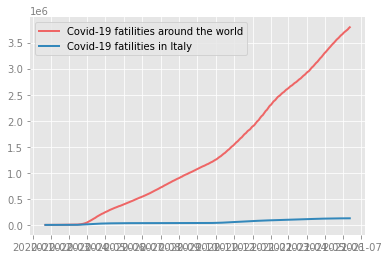

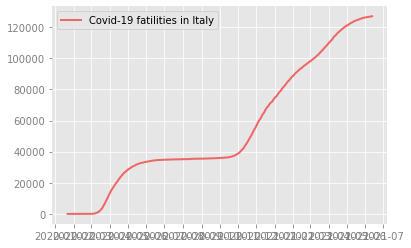

In [84]:
import matplotlib.dates as mdates
# mdates.DateFormatter()
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month

fig, ax = plt.subplots()
ax.plot(date,covid_data.groupby("Date").sum()[["Value"]], label = "Covid-19 fatilities around the world")
ax.plot(date,covid_data[covid_data["Country/Region"] == "Italy"].groupby("Date").sum()[["Value"]],label="Covid-19 fatilities in Italy")
ax.legend(loc='best')
# # format the ticks
ax.xaxis.set_major_locator(months)

# # round to nearest years.
# datemin = np.datetime64(min(covid_data['Date']), 'M') 
# datemax = np.datetime64(max(covid_data['Date']), 'M') 
# ax.set_xlim(datemin, datemax)
# plt.show()
fig, ax = plt.subplots()
ax.plot(date,covid_data[covid_data["Country/Region"] == "Italy"].groupby("Date").sum()[["Value"]],label="Covid-19 fatilities in Italy")
ax.legend(loc='best')
# # format the ticks
ax.xaxis.set_major_locator(months)
plt.show()


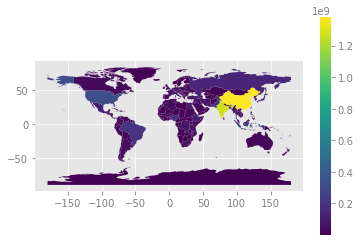

In [11]:
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(column='pop_est',legend = True)

In [54]:
covid_data = covid_data.rename(columns={"Long": "lon", "Lat": "lat","ISO 3166-1 Alpha 3-Codes":"iso_a3", "Country/Region": "location"})
# covid_data = covid_data[covid_data['Date'] == '2020-05-19']

In [55]:
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")

In [56]:
beds.head()
bed_map = dict(zip(beds['Country'],beds['ICU_Beds']))

In [57]:
print(bed_map)

{'Japan': 7.3, 'South Korea': 10.6, 'Russia': 8.3, 'Germany': 29.2, 'Austria': 21.8, 'Hungary': 13.8, 'Czech Republic': 11.6, 'Poland': 6.9, 'Lithuania': 15.5, 'France': 11.6, 'Slovakia': 9.2, 'Belgium': 15.9, 'Latvia': 9.7, 'Hong Kong': 7.1, 'Estonia': 14.6, 'Luxembourg': 24.8, 'Switzerland': 11.0, 'Slovenia': 6.4, 'China': 3.6, 'Greece': 6.0, 'Australia': 9.1, 'Norway': 8.0, 'Portugal': 4.2, 'Netherlands': 6.4, 'Finland': 6.1, 'Italy': 12.5, 'Iceland': 9.1, 'Israel': nan, 'Spain': 9.7, 'Ireland': 6.5, 'Turkey': 29.8, 'United States': 34.7, 'New Zealand': 3.67, 'Denmark': 6.7, 'United Kingdom': 6.6, 'Canada': 13.5, 'Sweden': 5.8, 'Chile': 6.0, 'Colombia': 0.9, 'India': 5.2, 'Mexico': 1.2, 'Africa': 0.1, 'Europe': 12.5, 'Asia': 6.1, 'North America': 14.6, 'South America': 3.0}


In [58]:
agegroups.head()
agegroups_map = dict(zip(agegroups['Location'],agegroups[agegroups.columns[2:12]].values))

In [59]:
print(agegroups_map)

{'World': array([1.342381e+09, 1.253463e+09, 1.192080e+09, 1.150350e+09,
       9.731550e+08, 8.336220e+08, 5.917860e+08, 3.124590e+08,
       1.241160e+08, 2.081400e+07]), 'Sustainable Development Goal (SDG) regions': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'Sub-Saharan Africa': array([3.24399e+08, 2.53430e+08, 1.85189e+08, 1.33417e+08, 8.92920e+07,
       5.64640e+07, 3.33850e+07, 1.51200e+07, 3.47700e+06, 1.91000e+05]), 'Eastern Africa': array([1.30038e+08, 1.05675e+08, 7.81560e+07, 5.41080e+07, 3.52710e+07,
       2.17140e+07, 1.28490e+07, 5.97800e+06, 1.51300e+06, 1.02000e+05]), 'Burundi': array([3.873e+06, 2.725e+06, 2.030e+06, 1.539e+06, 7.480e+05, 4.920e+05,
       3.390e+05, 1.120e+05, 3.000e+04, 2.000e+03]), 'Comoros': array([238000., 192000., 151000., 118000.,  77000.,  51000.,  30000.,
        12000.,   3000.,      0.]), 'Djibouti': array([197000., 180000., 177000., 162000., 121000.,  78000.,  44000.,
        22000.,   6000.,      0.]), 'Eritrea': array([

In [60]:
print(agegroups)

     Unnamed: 0                                    Location           0_9  \
0             0                                       World  1.342381e+09   
1             1  Sustainable Development Goal (SDG) regions           NaN   
2             2                          Sub-Saharan Africa  3.243990e+08   
3             3                              Eastern Africa  1.300380e+08   
4             4                                     Burundi  3.873000e+06   
..          ...                                         ...           ...   
236         236                               Liechtenstein  6.600000e+04   
237         237                                      Monaco  6.600000e+04   
238         238                       Saint Kitts and Nevis  2.200000e+04   
239         239                                  San Marino  6.600000e+04   
240         240                            Diamond Princess  1.600000e+01   

            10_19         20_29         30_39        40_49        50_59  \


In [61]:
probabilities.head()

,Age,prob_I_to_ICU_1,prob_ICU_to_Death_1,prob_I_to_ICU_2,prob_ICU_to_Death_2
0,0_9,0.001,0.00,0.001,0.00
1,10_19,0.003,0.00,0.003,0.00
2,20_29,0.009,0.05,0.006,0.00
3,30_39,0.025,0.06,0.009,0.00
4,40_49,0.030,0.10,0.025,0.12


In [62]:
#  store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

##SEIR MODEL


![SEIR MODEL](https://miro.medium.com/max/1400/1*05TbKHvwOerGixyTFTzNwA.png)

In [63]:
def deriv(y, t, beta, gamma, delta, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - delta * E
    dIdt = delta * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt


In [64]:
# omega = 0.04
# beta = 0.1
# gamma = 0.2

In [65]:
gamma = 1.0/14.0
delta = 1.0/9.0

def logistic_R_0(x, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-x+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(x):
        return logistic_R_0(x, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, delta, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

## Curve Fitting

In [66]:
data = covid_data[covid_data["location"] == "India"]["Value"].values[::-1]
agegroups = agegroups_map["India"]
beds_per_100k = bed_map["India"]
outbreak_shift = 30
params_init_min_max = {"R_0_start": (2.7, 1.0, 3.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 100), "R_0_end": (0.9, 0.3, 2),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [67]:
d = covid_data[covid_data["location"] == "India"]["Value"].values[::-1]

In [68]:
print(d)

[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      1
      1      2      2      2      2      3      3      4      5      4
      7     10     10     12     20     20     24     27     32     35
     58     72     72     86     99    136    150    178    226    246
    288    331    358    393    405    448    486    521    559    592
    645    681    721    780    825    881    939   1008   1079   1154
   1223   1323   1391   1566   1693   1785   1889   1985   2101   2212
   2294   2415   2551   2649   2753   2871   3025   3156   3302   3434
   3584   3726   3868   4024   4172   4344   4534   4711   4980   5185
   5408   5608   5829   6088   6363   6649   6946   7207   7473   7750
   810

In [69]:
d[99-30]

35

In [70]:
#covid_data[covid_data["location"] == "Italy"]

In [71]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

In [72]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

{'R_0_start': 2.9999999093752625,
 'k': 0.010000080858095063,
 'x0': 99.99999736568564,
 'R_0_end': 1.376235078053458,
 'prob_I_to_C': 0.0999999989372268,
 'prob_C_to_D': 0.7999999784841203,
 's': 0.00344274864737692}

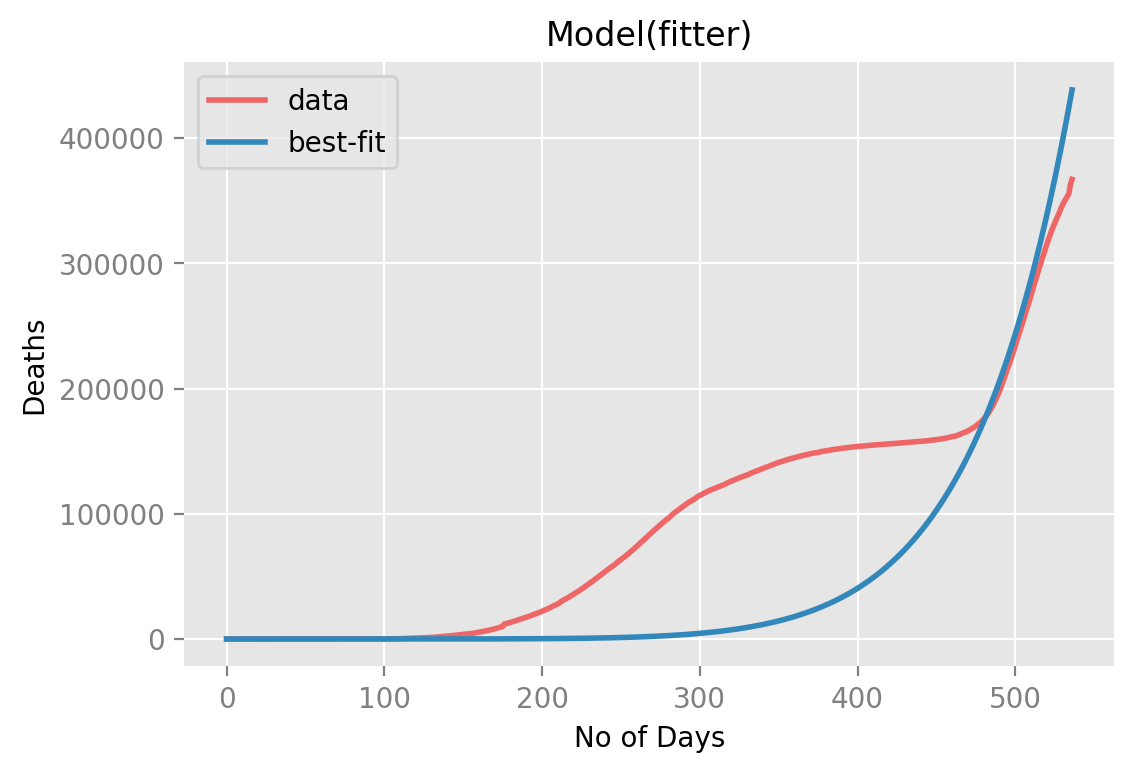

In [73]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)
fig = plt.figure(dpi = 200)
ax = fig.gca()
# plt.figsize()
result.plot_fit( ax = ax,datafmt="-",xlabel='No of Days', ylabel='Deaths')
result.best_values

In [75]:
t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D = Model(days, agegroups_map["Italy"], bed_map["Italy"], **result.best_values)

In [ ]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(delta*E[:i]) if sum(delta*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();


In [ ]:
full_days = 10
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for Italy")
plotter(*Model(full_days, agegroups_map["India"], bed_map["India"], **result.best_values))

In [ ]:
fig, ax = plt.subplots()
ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
ax.xaxis.set_major_locator(years)
ax.legend(loc='best')
plt.show()